In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tszip

In [2]:
data_dir = Path("../data")

In [3]:
# NOTE: The Pango labels in Viridian v04 are based on pangolin-data v1.21.
# For column info, see https://cov-lineages.org/resources/pangolin/output.html
pangolin_file = data_dir / "lineage_report.pangolin-data_v1.21.csv.gz"
pangolin_df = pd.read_csv(pangolin_file)
pangolin_df.head(1)

,taxon,lineage,conflict,ambiguity_score,scorpio_call,scorpio_support,scorpio_conflict,scorpio_notes,version,pangolin_version,scorpio_version,constellation_version,is_designated,qc_status,qc_notes,note
0,n0,B,0.0,NaN,NaN,NaN,NaN,NaN,PANGO-v1.21,4.3.1,0.3.19,v0.1.12,True,pass,Ambiguous_content:0.02,Assigned from designation hash.


In [4]:
# All passing pangolin QC for assignment.
print(sum(pangolin_df["qc_status"] == "pass") / len(pangolin_df))

1.0


Conflicts: 17163/206897 (8.30)%


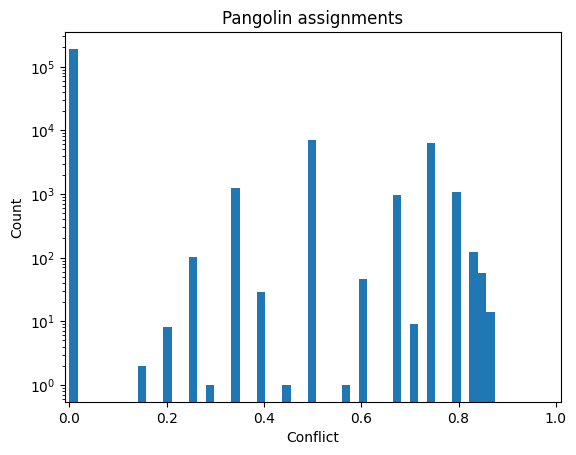

In [5]:
# "In the pangoLEARN model, a given sequence gets assigned to the most likely category based on known diversity.
# If a sequence can fit into more than one category, the conflict score will be greater than 0 and reflect 
# the number of categories the sequence could fit into. If the conflict score is 0, this means that within 
# the current decision tree there is only one category that the sequence could be assigned to."
num_conflict = sum(pangolin_df["conflict"] > 0)
perc_conflict = num_conflict / len(pangolin_df) * 100
print(f"Conflicts: {num_conflict}/{len(pangolin_df)} ({perc_conflict:.2f})%")

plt.title("Pangolin assignments")
plt.ylabel("Count")
plt.xlabel("Conflict")
plt.xlim(-0.01, 1.01)
plt.hist(pangolin_df["conflict"], bins=50, log=True);

In [6]:
pangolin_df = pangolin_df[["taxon", "lineage"]]
pangolin_df.columns = ["taxon", "lineage_pd_v1.21"]

In [7]:
ts_file = data_dir / "v1-beta1_2023-02-21.pp.md.bpshift.ts.dated.il.tsz"
ts = tszip.decompress(ts_file)

In [8]:
imputed_pangos = []
for node in ts.nodes():
    if node.is_sample():
        continue
    imputed_pangos.append(
        {
            "taxon": "n" + str(node.id),
            "lineage_imputed": node.metadata["Imputed_Viridian_pangolin"],
        }
    )
imputed_df = pd.DataFrame(imputed_pangos)
imputed_df.head(1)

,taxon,lineage_imputed
0,n0,B


In [9]:
# Check that internal nodes align.
assert all(pangolin_df["taxon"] == imputed_df["taxon"])
merged_df = pangolin_df.merge(imputed_df, on="taxon")
len(merged_df)

206897

Count identical cases

In [10]:
num_identical = sum(merged_df["lineage_pd_v1.21"] == merged_df["lineage_imputed"])
perc_identical = num_identical / len(merged_df)
print(f"Identical: {num_identical}/{len(imputed_df)} ({perc_identical * 100:.2f}%)")

Identical: 186741/206897 (90.26%)


Examine discordant cases

In [11]:
is_discordant = merged_df["lineage_pd_v1.21"] != merged_df["lineage_imputed"]
discordant_df = merged_df[is_discordant].reset_index(drop=True)
discordant_df.head(1)

,taxon,lineage_pd_v1.21,lineage_imputed
0,n318,B.1.1.71,B.1.1


In [12]:
import json
import urllib.request
alias_key_url = "https://raw.githubusercontent.com/cov-lineages/pango-designation/refs/heads/master/pango_designation/alias_key.json"
with urllib.request.urlopen(alias_key_url) as url:
    alias_key = json.load(url)

In [13]:
lineage_notes_url = "https://raw.githubusercontent.com/cov-lineages/pango-designation/refs/heads/master/lineage_notes.txt"
lineage_notes = pd.read_csv(lineage_notes_url, sep="\t")
lineage_notes.head(1)

,Lineage,Description
0,A,One of the two original haplotypes of the pand...


In [14]:
# Some of the Pango labels in the discordant cases are withdrawn.
num_withdrawn_lineage_pd_v121 = sum(~merged_df["lineage_pd_v1.21"].isin(lineage_notes["Lineage"]))
num_withdrawn_lineage_imputed = sum(~merged_df["lineage_imputed"].isin(lineage_notes["Lineage"]))
print(f"Total: {len(merged_df)}")
print(f"Withdrawn (pangolin-assigned): {num_withdrawn_lineage_pd_v121}")
print(f"Withdrawn (sc2ts-imputed): {num_withdrawn_lineage_imputed}")

Total: 206897
Withdrawn (pangolin-assigned): 3
Withdrawn (sc2ts-imputed): 976


In [15]:
def _remap(x):
    if x.endswith("*"):
        x = x[:-1]
    split = x.split(".")
    alias = alias_key.get(split[0], "")
    if alias != "":
        x = ".".join([alias] + split[1:])
    return x


identical_remapped = 0
sc2ts_unknown = 0   # unknown
sc2ts_r = [] # Unknown (R)
sc2ts_more_specific = []
pangolin_more_specific = []
other_cases = []

for i, row in merged_df.iterrows():
    if row["lineage_imputed"] == "Unknown":
        sc2ts_unknown += 1
        continue

    # Examine these case further.
    if row["lineage_imputed"] == "Unknown (R)":
        sc2ts_r.append(row["lineage_pd_v1.21"])
        continue

    # Decompress if not a Pango X.
    if row["lineage_pd_v1.21"].startswith("X"):
        pango_v121 = row["lineage_pd_v1.21"]
    else:
        pango_v121 = _remap(row["lineage_pd_v1.21"])

    if row["lineage_imputed"].startswith("X"):
        pango_imputed = row["lineage_imputed"]
    else:
        pango_imputed = _remap(row["lineage_imputed"])

    # Great, nothing to do.
    if pango_v121 == pango_imputed:
        identical_remapped += 1
        continue

    # Examine these case further.
    if pango_imputed.startswith(pango_v121 + "."):
        sc2ts_more_specific.append((pango_v121, pango_imputed))
    elif pango_v121.startswith(pango_imputed + "."):
        pangolin_more_specific.append((pango_v121, pango_imputed))
    else:
        other_cases.append((pango_v121, pango_imputed))

print(f"identical: {identical_remapped}")
print(f"sc2ts unknown: {sc2ts_unknown}")
print(f"sc2ts R: {len(sc2ts_r)}")
print(f"sc2ts-imputed more specific: {len(sc2ts_more_specific)}")
print(f"pangolin-assigned more specific: {len(pangolin_more_specific)}")
print(f"other: {len(other_cases)}")

identical: 186741
sc2ts unknown: 43
sc2ts R: 929
sc2ts-imputed more specific: 18077
pangolin-assigned more specific: 627
other: 480


Examine recombinant nodes

In [16]:
# Most of the Pango X-associated nodes are not assigned to a Pango X by pangolin.
[x for x in sc2ts_r if x.startswith("X")]

['XM',
 'XF',
 'XM',
 'XL',
 'XQ',
 'XG',
 'XM',
 'XM',
 'XW',
 'XY',
 'XBG',
 'XBM',
 'XBB',
 'XBF',
 'XBB.1',
 'XBB.1.5.4']

Examine pangonet-based node distances of other cases

In [17]:
import nb_utils
rebar_dir = data_dir / ".." / "notebooks" / "dataset" / "rebar"
alias_key_file = rebar_dir / "alias_key.json"
lineage_notes_file = rebar_dir / "lineage_notes.txt"
pangonet = nb_utils.initialise_pangonet(alias_key_file, lineage_notes_file)

/opt/homebrew/Cellar/micromamba/2.0.8/envs/sc2ts/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-03-31 13:06:05,041 INFO:Creating aliases.
2025-03-31 13:06:05,046 INFO:Creating network.


In [18]:
from collections import Counter


def compute_node_distances(cases):
    case_counts = Counter(cases)
    valid_pangos = lineage_notes["Lineage"].to_list()
    num_withdrawn_cases = 0
    num_pango_Xs = 0
    nd_discordant_cases = np.zeros(len(case_counts), dtype=np.int32) - 1
    pangonet_node_dist = []
    for i, labels in enumerate(case_counts):
        if (labels[0] not in valid_pangos) or (labels[1] not in valid_pangos):
            num_withdrawn_cases += 1
            continue
        if labels[0].startswith("X") or labels[1].startswith("X"):
            num_pango_Xs += 1
            continue
        nd = nb_utils.get_node_distance(pangonet, label_1=labels[0], label_2=labels[1])
        nd_discordant_cases[i] = nd
        pangonet_node_dist.append(
            {
                "pango_labels": labels,
                "node_distance": nd,
                "num_cases": case_counts[labels],
            }
        )
    nd_df = pd.DataFrame(pangonet_node_dist)\
        .sort_values(by=["node_distance", "num_cases"], ascending=False)\
        .reset_index(drop=True)
    print(f"Pango Xs (un-defined distance): {num_pango_Xs}")
    print(f"Withdrawn (un-defined distance): {num_withdrawn_cases}")
    print(f"Other cases (defined distance): {len(nd_discordant_cases)}")
    print(f"Other cases (node distance <= 2): {np.sum(nd_discordant_cases <= 2)}")
    return nd_df

In [19]:
pd.set_option('display.max_rows', 100)
compute_node_distances(sc2ts_more_specific)

Pango Xs (un-defined distance): 9
Withdrawn (un-defined distance): 234
Other cases (defined distance): 324
Other cases (node distance <= 2): 323


,pango_labels,node_distance,num_cases
0,"(B, B.1.110.2)",3,1
1,"(B.1, B.1.177.17)",2,38
2,"(B.1, B.1.177.16)",2,27
3,"(B.1, B.1.177.32)",2,9
4,"(B.1, B.1.177.72)",2,5
5,"(B.1, B.1.177.20)",2,3
6,"(B.1, B.1.177.19)",2,2
7,"(B.1, B.1.177.21)",2,2
8,"(B.1, B.1.177.56)",2,1
9,"(B.1, B.1.177.10)",2,1


In [20]:
pd.set_option('display.max_rows', 150)
compute_node_distances(pangolin_more_specific)

Pango Xs (un-defined distance): 26
Withdrawn (un-defined distance): 163
Other cases (defined distance): 315
Other cases (node distance <= 2): 315


,pango_labels,node_distance,num_cases
0,"(B.1.9.5, B.1)",2,1
1,"(B.1.36.7, B.1)",2,1
2,"(A.2.5.2, A.2)",2,1
3,"(B.1.1.222, B.1.1)",1,26
4,"(B.1.404, B.1)",1,8
5,"(B.33, B)",1,7
6,"(B.1.258, B.1)",1,7
7,"(B.1.1.305, B.1.1)",1,5
8,"(B.1.1.253, B.1.1)",1,4
9,"(B.1.1.432, B.1.1)",1,4


In [21]:
pd.set_option('display.max_rows', 100)
compute_node_distances(other_cases)

Pango Xs (un-defined distance): 3
Withdrawn (un-defined distance): 84
Other cases (defined distance): 109
Other cases (node distance <= 2): 108


,pango_labels,node_distance,num_cases
0,"(B, A.5)",3,1
1,"(B.1.1.222, B.1.1.519)",2,184
2,"(B.1.564, B.1.369)",2,10
3,"(B.1.596, B.1.2)",2,6
4,"(B.1.577, B.1.595)",2,5
5,"(B.1.36.8, B.1.36.21)",2,4
6,"(B.1.36.38, B.1.36.17)",2,3
7,"(B.1.560, B.1.1)",2,2
8,"(B.1.1, B.1.560)",2,2
9,"(B.1.1.315, B.1.1.25)",2,2
